# Exploration of Nova Bugs

This notebook is part of an overall experiment looking at the ability
to algorithmically (through tuned algorithms and machine learning techniques)
process large backlogs of bugs in Open Source Projects. One of the key 
challenges to maintainer burn out is an ever increasing pile of bugs that
often represent the same or similar issues, and take far too much human
time to keep on top of.

This work is done with the OpenStack Nova project as a starting point because
I've personally looked at 2000 - 4000 of the total 13000 in the backlog over 
the years, so have grounding on what is important and what is not. The intent
is to use this to develop approaches that could be expanded to other projects.

## Bug Processing Pipeline

The bugs for Nova are stored in launchpad. There is an API to extract bugs, 
but it is extremely slow. A extract of the fields required for Nova's 13K bugs takes
6 - 8 hours. As such, an extract is provided in `bugs/nova/2017-10-11` as a series
of json files.

In order to make adhoc query of these bugs easier, they are then loaded into a
`mongodb` database. In order to replicate this notebook you will need to install
mongodb locally. On Ubuntu/Debian Linux this is done with:

```
  sudo apt-get install mongodb
  sudo systemctrl start mongodb
```


In [76]:
# Run this to get a base loaded
%matplotlib inline

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = [16, 9]

import pandas as pd
import pymongo
from pymongo import MongoClient
import json
import glob

client = MongoClient()

db = client.test_database
bugs = db.bugs
# Drop any existing db to ensure that we don't have data from a past run
bugs.drop()
# Creating this index ensures no duplicate entries can get in
bugs.create_index([('id', pymongo.ASCENDING)], unique=True)


def load_bugs_into_db():
    for file in glob.glob("bugs/nova/2017-10-17/*.json"):
        with open(file) as f:
            bug = json.loads(f.read())
            bugs.insert_one(bug)
            
load_bugs_into_db()
bugs.count()

13251

## All Bugs in a DataFrame

We start by loading all bugs into a dataframe which is index by create time, that lets us begin to explore bugs over time in graphs and tables. 

To ensure this data looks right we do dump out the first 5 rows.

In [77]:
# Make a query to the specific DB and Collection
cursor = bugs.find()

# Expand the cursor and construct the DataFrame
df =  pd.DataFrame(list(cursor))

df.head()
df['created'] =  pd.to_datetime(df['created'])
df.head()
df.index = df['created']
df.head()

,_id,closed,comments,created,description,heat,id,importance,index,last_updated,link,openned,owner,status,tags,title
created,,,,,,,,,,,,,,,,
2015-11-18 08:43:56.990077,59e7a360d6a7d41cb37827b3,2015-11-19 15:54:21.778204+00:00,"[{'content': 'Hi , Trying to submit a path to...",2015-11-18 08:43:56.990077,"Hi , \nTrying to submit a path to upstream tem...",6,1517367,Undecided,7123,2015-11-19 15:54:24.354757+00:00,https://bugs.launchpad.net/nova/+bug/1517367,2015-11-18 08:43:56.990077+00:00,None,Invalid,[xenserver],unable to boot instance after image reactivate...
2010-08-25 10:07:20.041170,59e7a360d6a7d41cb37827b4,2010-09-08 18:55:42.306442+00:00,[{'content': 'i have setup the nova environmen...,2010-08-25 10:07:20.041170,"i have setup the nova environment, and come a...",6,623888,Undecided,3188,2012-02-21 01:37:51.035670+00:00,https://bugs.launchpad.net/nova/+bug/623888,2010-08-25 10:07:20.041170+00:00,https://api.launchpad.net/1.0/~mitch-garnaat,Invalid,[],euca-upload-bundle doesn't work with boto 2
2013-08-24 01:33:20.672518,59e7a360d6a7d41cb37827b5,2013-12-04 10:07:01.615662+00:00,[{'content': '[composite:openstack_compute_api...,2013-08-24 01:33:20.672518,[composite:openstack_compute_api_v3]\nuse = ca...,6,1216176,Medium,3538,2014-04-17 08:49:09.865686+00:00,https://bugs.launchpad.net/nova/+bug/1216176,2013-08-24 01:33:20.672518+00:00,https://api.launchpad.net/1.0/~xuhj,Fix Released,[api],v3 api still use v2 ratelimit middleware
2015-04-09 19:20:08.444183,59e7a360d6a7d41cb37827b6,2015-08-18 22:52:25.744704+00:00,[{'content': 'Not quite sure if this is a secu...,2015-04-09 19:20:08.444183,This issue is being treated as a potential sec...,10,1442333,Undecided,6767,2015-08-18 22:52:40.933442+00:00,https://bugs.launchpad.net/nova/+bug/1442333,2015-04-09 19:20:08.444183+00:00,None,Invalid,[],Floating IP is reused after nodeB deletion and...
2012-08-24 01:18:12.859503,59e7a360d6a7d41cb37827b7,2012-09-19 06:32:30.879797+00:00,[{'content': 'Horizon is unable to retrieve qu...,2012-08-24 01:18:12.859503,Horizon is unable to retrieve quota informatio...,40,1040956,Critical,77,2012-09-27 15:30:07.547930+00:00,https://bugs.launchpad.net/nova/+bug/1040956,2012-08-26 19:44:04.437325+00:00,https://api.launchpad.net/1.0/~danwent,Fix Released,[quantum],'Unable to get quota information' in horizon w...


## Resampling Data for binning

Individual bugs over time are really hard to get a picture of any trends or what is going on. To ensure that we don't have any odd missing gaps, like a whole year missing, we resample the data to be in weekly bins.

When resampling data you need to specify what group opperation you are going to do with it. In our case, just counting is fine. As the counts of all fields are going to be the same, we can just count the id column. That also provides us with the facility to see what the data looks like on a **weekly** basis.

In [78]:
df2 = df.resample('w').count()[['id']]
df2.describe()

,id
count,393.000000
mean,33.717557
std,17.101114
min,0.000000
25%,23.000000
50%,32.000000
75%,44.000000
max,89.000000


## Bugs openned per week for life of project

This graphs the bugs openned per week for the life of the project. You can see activity spikes in the data which land on releases, some dips around holidays. Most importantly there aren't holes.

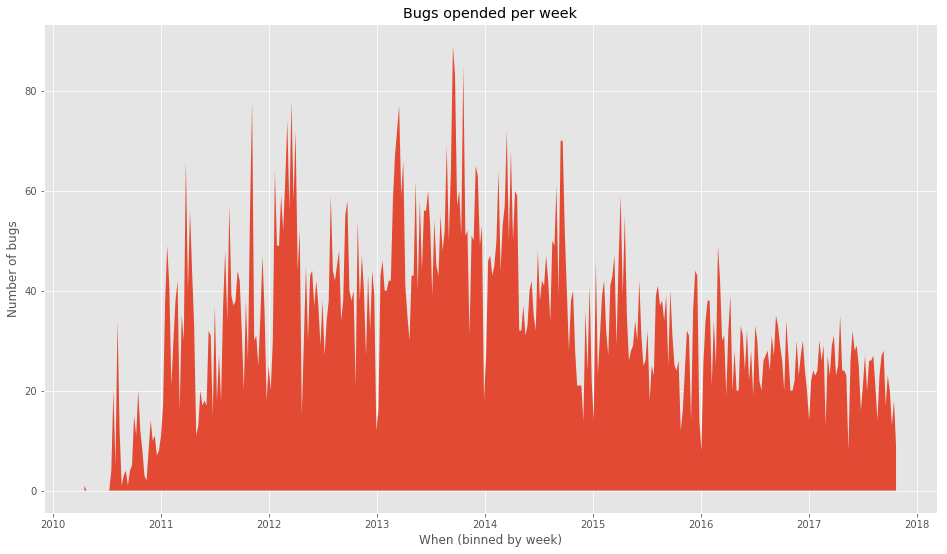

In [79]:
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as dates
matplotlib.style.use('ggplot')

# Do a dateplot of the bugs to ensure that we're not missing anything, these are binned by week.

ax = plt.subplot()
ax.stackplot(df2.index.to_pydatetime(), df2.id)
ax.set_ylabel("Number of bugs")
ax.set_xlabel("When (binned by week)")
ax.set_title("Bugs opended per week")
ax.xaxis_date()


## Bugs by closed time

This shows bugs by closed time, which is the last time the bug is put into a closed state, one of **Invalid**, **Won't Fix**, **Opinion**, **Fix Committed** or **Fix Release**.

It's interesting to see that even though bugs come in at a more or less constant rate the weekly bug close rate varies a lot, and there are clearly pushes and sweeps to get things under control. It was worse in the past then it currently is.

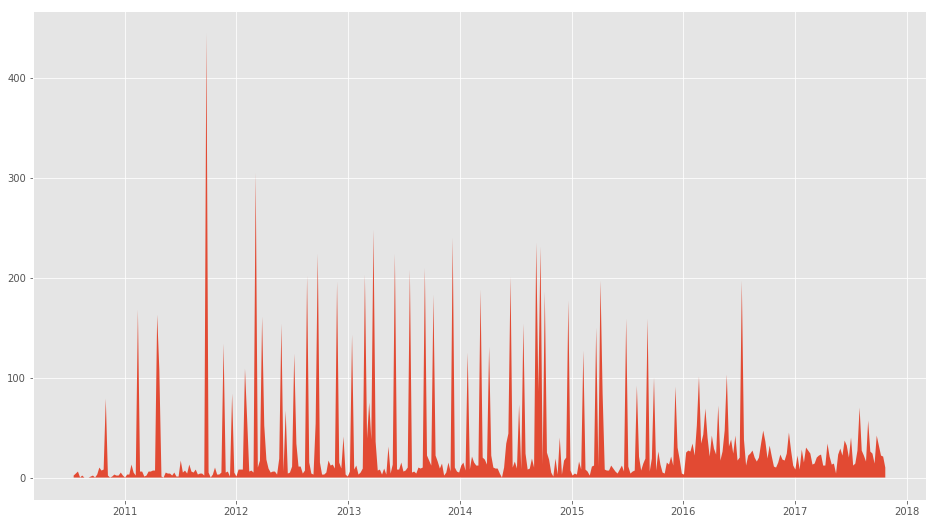

In [80]:
df_closed = df.copy()
df_closed['closed'] = pd.to_datetime(df_closed['closed'])
df_closed.index = df_closed['closed']
df_closed = df_closed.resample('w').count()[['id']]


ax_up = plt.subplot()
ax_up.stackplot(df_closed.index.to_pydatetime(), df_closed.id)
ax_up.xaxis_date()

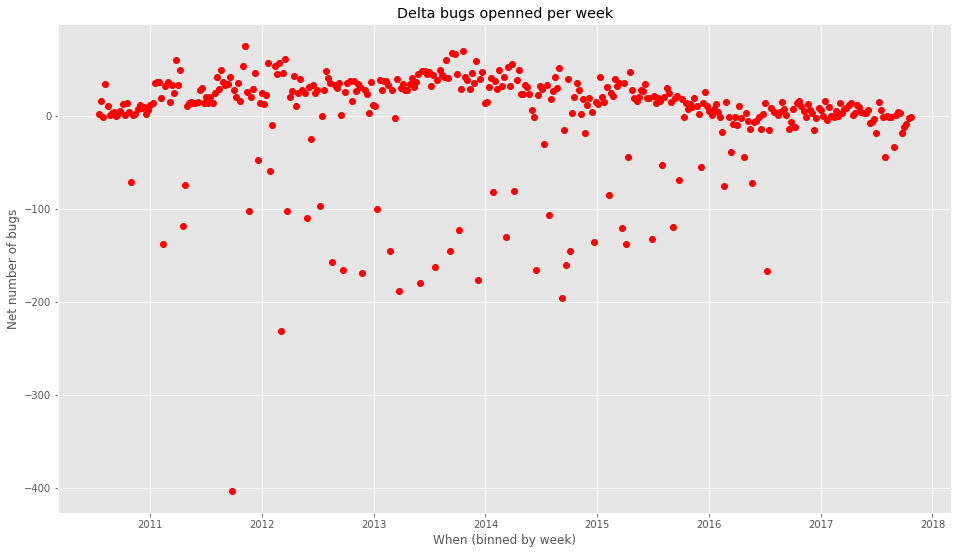

In [81]:
df_delta = df2 - df_closed

ax_delta = plt.subplot()
ax_delta.plot(df_delta.index.to_pydatetime(), df_delta.id, 'ro')
ax_delta.set_ylabel("Net number of bugs")
ax_delta.set_xlabel("When (binned by week)")
ax_delta.set_title("Delta bugs openned per week")
ax_delta.xaxis_date()

## How long are bugs ope

## Tag exploration

One of the goals of doing learning analysis on this content is going to be seeing if there are tags that should be applied to bugs that are not. Lets just get a handle on what tags exist against artifacts. This is going to require a different pull of the data. Here we go back to mongo and build a dataframe which unrolls the tag field, so if a bug had 3 tags on it, we'll get 3 rows here, with the same created and id fields.

In [82]:
# Make a query to the specific DB and Collection
cursor = bugs.find()

# Expand the cursor and construct the DataFrame, we need to do some unrolling because tags are nested
all_bugs = list(cursor)
all_tags = []
for bug in all_bugs:
    for tag in bug['tags']:
        all_tags.append(
            {"created": bug["created"],
             "tag": tag,
             "id": bug["id"]}
        )
df_tags = pd.DataFrame(all_tags)
df_tags.head()

,created,id,tag
0,2015-11-18 08:43:56.990077+00:00,1517367,xenserver
1,2013-08-24 01:33:20.672518+00:00,1216176,api
2,2012-08-24 01:18:12.859503+00:00,1040956,quantum
3,2017-02-02 10:04:09.662955+00:00,1661195,api
4,2013-12-09 17:45:15.504424+00:00,1259262,api


Do some basic statistics on the top 30 tags to figure out what these look like. This gives an idea of what the top tags are.

In [83]:
df_tags.count()
df_tags['created'] = pd.to_datetime(df_tags['created'])
df_tag_counts = df_tags.tag.value_counts()
print(df_tag_counts.head(30))
df_tag_counts.describe()

api                            726
libvirt                        691
compute                        492
network                        403
vmware                         402
low-hanging-fruit              364
volumes                        358
testing                        337
xenserver                      265
db                             258
live-migration                 188
scheduler                      183
nova                           178
cells                          176
ec2                            157
hyper-v                        149
neutron                        146
placement                      132
havana-backport-potential      130
ironic                         122
verification-done              119
baremetal                      114
icehouse-backport-potential    113
in-stable-icehouse             109
verification-needed            107
unified-objects                102
doc                             99
in-stable-juno                  93
ntt                 

count    866.000000
mean      13.071594
std       52.860265
min        1.000000
25%        1.000000
50%        1.000000
75%        4.000000
max      726.000000
Name: tag, dtype: float64

## Building a cross table

A crosstable ends up taking that list of tags, and pivoting it out so that we've now got one column per tag, and a 1 or 0 if that shows up at each point in time in the index. This ends up being what we'll need to graph these againt each other. We can then resample to something more meaningful, like Quarterly buckets. Because all our values of 0 or 1, we can use the **sum** operator to add up what we've got.

Then we graph it for the top 30. Which is honestly a mess, as it's way too much data. It looks like a psychadelic layer cake.

tag                         0.3  1.2.7  13.04  2.7.9  2012.2  2013.2.1  \
created                                                                  
2010-04-14 16:30:35.240910    0      0      0      0       0         0   
2010-07-16 15:59:07.906456    0      0      0      0       0         0   
2010-07-19 17:31:04.222695    0      0      0      0       0         0   
2010-07-20 19:03:56.524655    0      0      0      0       0         0   
2010-07-21 18:14:07.569251    0      0      0      0       0         0   

tag                         2014.2.3  3rdparty-ci  404  500-error    ...      \
created                                                              ...       
2010-04-14 16:30:35.240910         0            0    0          0    ...       
2010-07-16 15:59:07.906456         0            0    0          0    ...       
2010-07-19 17:31:04.222695         0            0    0          0    ...       
2010-07-20 19:03:56.524655         0            0    0          0    ...       
2

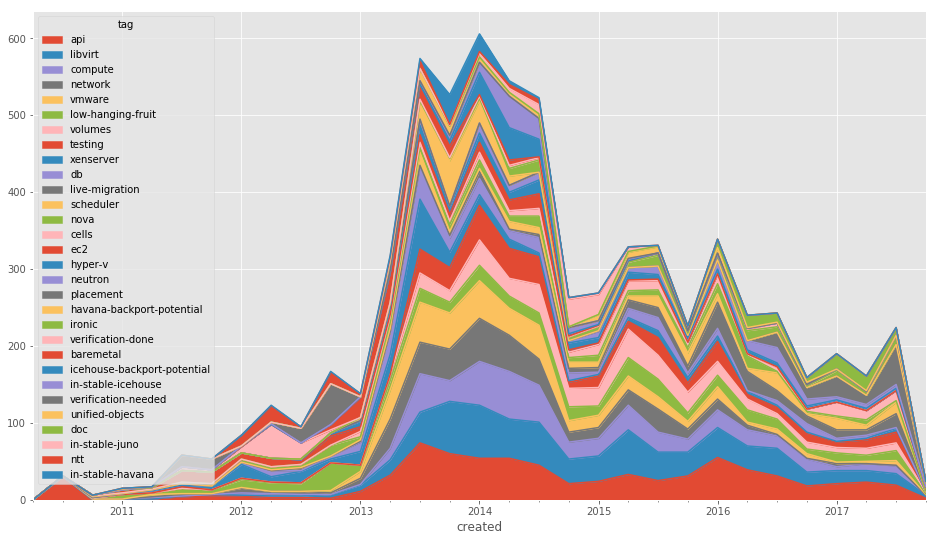

In [84]:
table = pd.crosstab(index=[df_tags['created']], columns=[df_tags['tag']])
print(table.head())
resample = table.resample("Q").sum()[df_tag_counts[:30].index]

resample.plot(kind="area")
#ax_tag = plt.subplot()
#ax_tag.stackplot(resample.index.to_pydatetime(), resample)
#ax_tag.xaxis_date()